# Tweet Sentiment Classification Models

## Import packages

In [1]:
# Import Packages for Feature Extraction
import pandas as pd
import numpy
import nltk
#nltk.download()
import gensim
import re
import scipy.sparse as sp
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import itertools

In [2]:
# Import Linear Regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

# Import Scalers
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


## Setup Environment and Preprocess Text

In [3]:
# create training and testing dataframes
training = pd.read_csv('train.csv')
testing = pd.read_csv('test.csv')

# drop null values from both
training.dropna(inplace = True)
testing.dropna(inplace = True)


# randomize the training sample set
training = training.sample(n = 10000, random_state = 420)


numRows_train = len(training)
numRows_test = len(testing)
print('The number of training rows is ', numRows_train)
print('The number of testing rows is ', numRows_test)

train_negatives = training[training['Sentiment'] == 0]
test_negatives = testing[testing['Sentiment'] == 0]
numNegatives_train = len(train_negatives)
numNegatives_test = len(test_negatives)
print('The number of training negatives is ', numNegatives_train)
print('The number of testing negatives is ', numNegatives_test)

train_positives = training[training['Sentiment'] == 1]
test_positives = testing[testing['Sentiment'] == 1]
numPositives_train = len(train_positives)
numPositives_test = len(test_positives)
print('The number of training positives is ', numPositives_train)
print('The number of testing positives is ', numPositives_test)



# Remove all words that start with @ or http and separate contractions
training['Text'] = training['Text'].apply(lambda x: contractions.fix(re.sub(r'@\w+|http\S+', '', x)))
testing['Text'] = testing['Text'].apply(lambda x: contractions.fix(re.sub(r'@\w+|http\S+', '', x)))

# Remove all words that start with @ or http and separate contractions
training['Text'] = training['Text'].apply(lambda x: x.lower())
testing['Text'] = testing['Text'].apply(lambda x: x.lower())

# Remove any non alphabetic character
training['Text'] = training['Text'].apply(lambda x: (re.sub('[^a-zA-Z\s\u00A0\xa0]+', '', x)))
testing['Text'] = testing['Text'].apply(lambda x: (re.sub('[^a-zA-Z\s\u00A0\xa0]+', '', x)))


The number of training rows is  10000
The number of testing rows is  359
The number of training negatives is  7666
The number of testing negatives is  177
The number of training positives is  2334
The number of testing positives is  182


### Create corpuses with and without stop words

In [4]:
from nltk.corpus import stopwords 

# Create corpuses to add sentences to

# TRAIN
train_corpus = []
for sentence in training['Text']:
    train_corpus.append(sentence) # add each line from dataframe into corpus



# TEST
test_corpus = []
for sentence in testing['Text']:
    test_corpus.append(sentence) # add each line from dataframe into corpus


# REMOVE STOP WORDS

# Download the stop words list if necessary 
#nltk.download('stopwords') 

# set the language to english for stop words
stop_words = set(stopwords.words('english'))

# make both corpuses
train_corpus_stop = []
test_corpus_stop = []

# remove stop words from the training sentences

# TRAIN
train_sentences = []

for sentence in train_corpus:
    word_tokens = nltk.word_tokenize(sentence) # tokenize each line
    sentence = [w for w in word_tokens if not w.lower() in stop_words] # remove stop words
    train_corpus_stop.append(sentence) # add the filtered and tokenized words back into corpus

# bring these words back together as a sentence
for words in train_corpus_stop:
    sentence = ' '.join(words)
    train_sentences.append(sentence)


training['Text_Stop'] = train_sentences

# TEST
test_sentences = []

for sentence in test_corpus:
    word_tokens = nltk.word_tokenize(sentence) # tokenize each line
    sentence = [w for w in word_tokens if not w.lower() in stop_words] # remove stop words
    test_corpus_stop.append(sentence) # add the filtered and tokenized words back into corpus

# bring these words back together as a sentence
for words in test_corpus_stop:
    sentence = ' '.join(words)
    test_sentences.append(sentence)


testing['Text_Stop'] = test_sentences



### Lemmatize words to meaningfully reduce number of unique words

In [5]:
from nltk.stem import WordNetLemmatizer

# Create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a sentence
def lemmatize_sentence(sentence):
    # This function takes a sentence as input and returns the lemmatized version of the sentence.
    
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)
    # Lemmatize each word in the sentence
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a sentence
    lem_sentence = " ".join(lem_words)
    return lem_sentence

# Apply the lemmatize_sentence function to the Text_Stop column of the training and testing DataFrames
training['Text_Lemma'] = training['Text_Stop'].apply(lemmatize_sentence)
testing['Text_Lemma'] = testing['Text_Stop'].apply(lemmatize_sentence)

## Make classification models for each of text processing models:

## Bag of Words

### Training Data BOW Processing, (No Longer Used)

In [123]:
"""
# BOW 
word2count_train = {} # find counts for all words?


for data in training['Text_Stop']:
    words = nltk.word_tokenize(data) # tokenize words in corpus
    for word in words:
        if word not in word2count_train.keys(): # if you find a new word
            word2count_train[word] = 1
        else:
            word2count_train[word] += 1 # else, if you find a word that's already been seen


unique_words_train = list(word2count_train.keys()) # make a list of all the unique words found

BOW_train = []


for data in training['Text_Stop']:
    words = nltk.word_tokenize(data)
    bag_vector = numpy.zeros(len(unique_words_train))
    for w in words:
        for i, word in enumerate(unique_words_train):
                if word == w:
                    bag_vector[i] += 1
    BOW_train.append(bag_vector)

BOW_train_docs = [' '.join(map(str, vec)) for vec in BOW_train]  # combine bag of words for each document into a string
"""

### Testing Data BOW Processing, (No Longer Used)

In [124]:
"""
# BOW 
word2count_test = {} # find counts for all words?


for data in testing['Text_Stop']:
    words = nltk.word_tokenize(data) # tokenize words in corpus
    for word in words:
        if word not in word2count_test.keys(): # if you find a new word
            word2count_test[word] = 1
        else:
            word2count_test[word] += 1 # else, if you find a word that's already been seen


unique_words_test = list(word2count_test.keys()) # make a list of all the unique words found

BOW_test = []


for data in testing['Text_Stop']:
    words = nltk.word_tokenize(data)
    bag_vector = numpy.zeros(len(unique_words_test))
    for w in words:
        for i, word in enumerate(unique_words_test):
                if word == w:
                    bag_vector[i] += 1
    BOW_test.append(bag_vector)


BOW_test_docs = [' '.join(map(str, vec)) for vec in BOW_test]

"""

### Build Classification Models for BOW

In [37]:
BOW = CountVectorizer()

# chose to use lemmatized text, though the improvements were small
x_train = BOW.fit_transform(training['Text_Lemma'])
y_train = training['Sentiment']

x_test = BOW.transform(testing['Text_Lemma'])
y_test = testing['Sentiment']

# Use SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state = 420)
x_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, y_train)

# Create models to be trained
lc_BOW = LogisticRegression()
svc_BOW = SVC(probability=True)
nbc_BOW = GaussianNB()
rfc_BOW = RandomForestClassifier()

# TRAIN data
lc_BOW.fit(x_train_oversampled, y_train_oversampled)
svc_BOW.fit(x_train_oversampled, y_train_oversampled)
nbc_BOW.fit(x_train_oversampled.toarray(), y_train_oversampled)  # Convert to dense array here
rfc_BOW.fit(x_train_oversampled, y_train_oversampled)


RandomForestClassifier()

### Test Classification Models for BOW

Linear Regression: 
               precision    recall  f1-score   support

           0       0.69      0.76      0.72       177
           1       0.74      0.66      0.70       182

    accuracy                           0.71       359
   macro avg       0.71      0.71      0.71       359
weighted avg       0.71      0.71      0.71       359

SVM: 
               precision    recall  f1-score   support

           0       0.56      0.89      0.69       177
           1       0.75      0.34      0.46       182

    accuracy                           0.61       359
   macro avg       0.66      0.61      0.58       359
weighted avg       0.66      0.61      0.58       359

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.59      0.73      0.65       177
           1       0.66      0.50      0.57       182

    accuracy                           0.62       359
   macro avg       0.62      0.62      0.61       359
weighted avg       0.62      0.

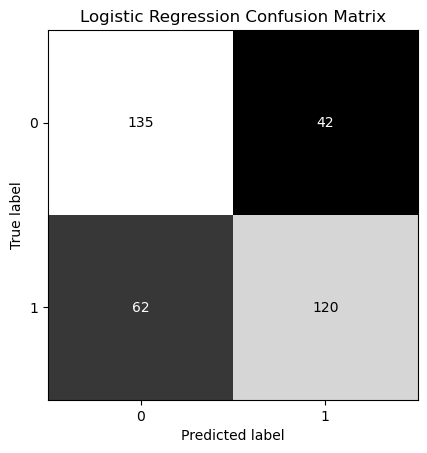

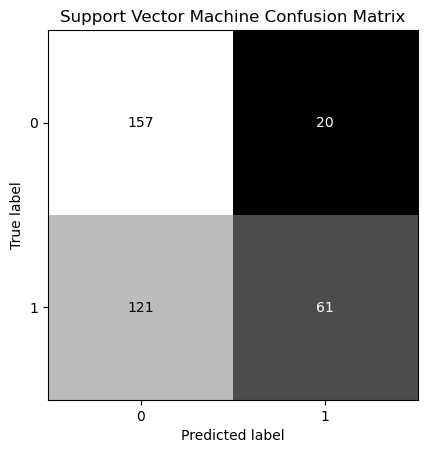

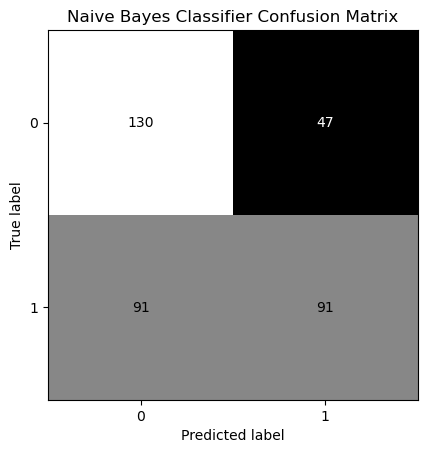

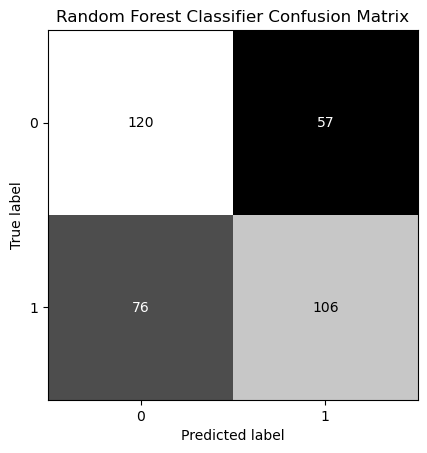

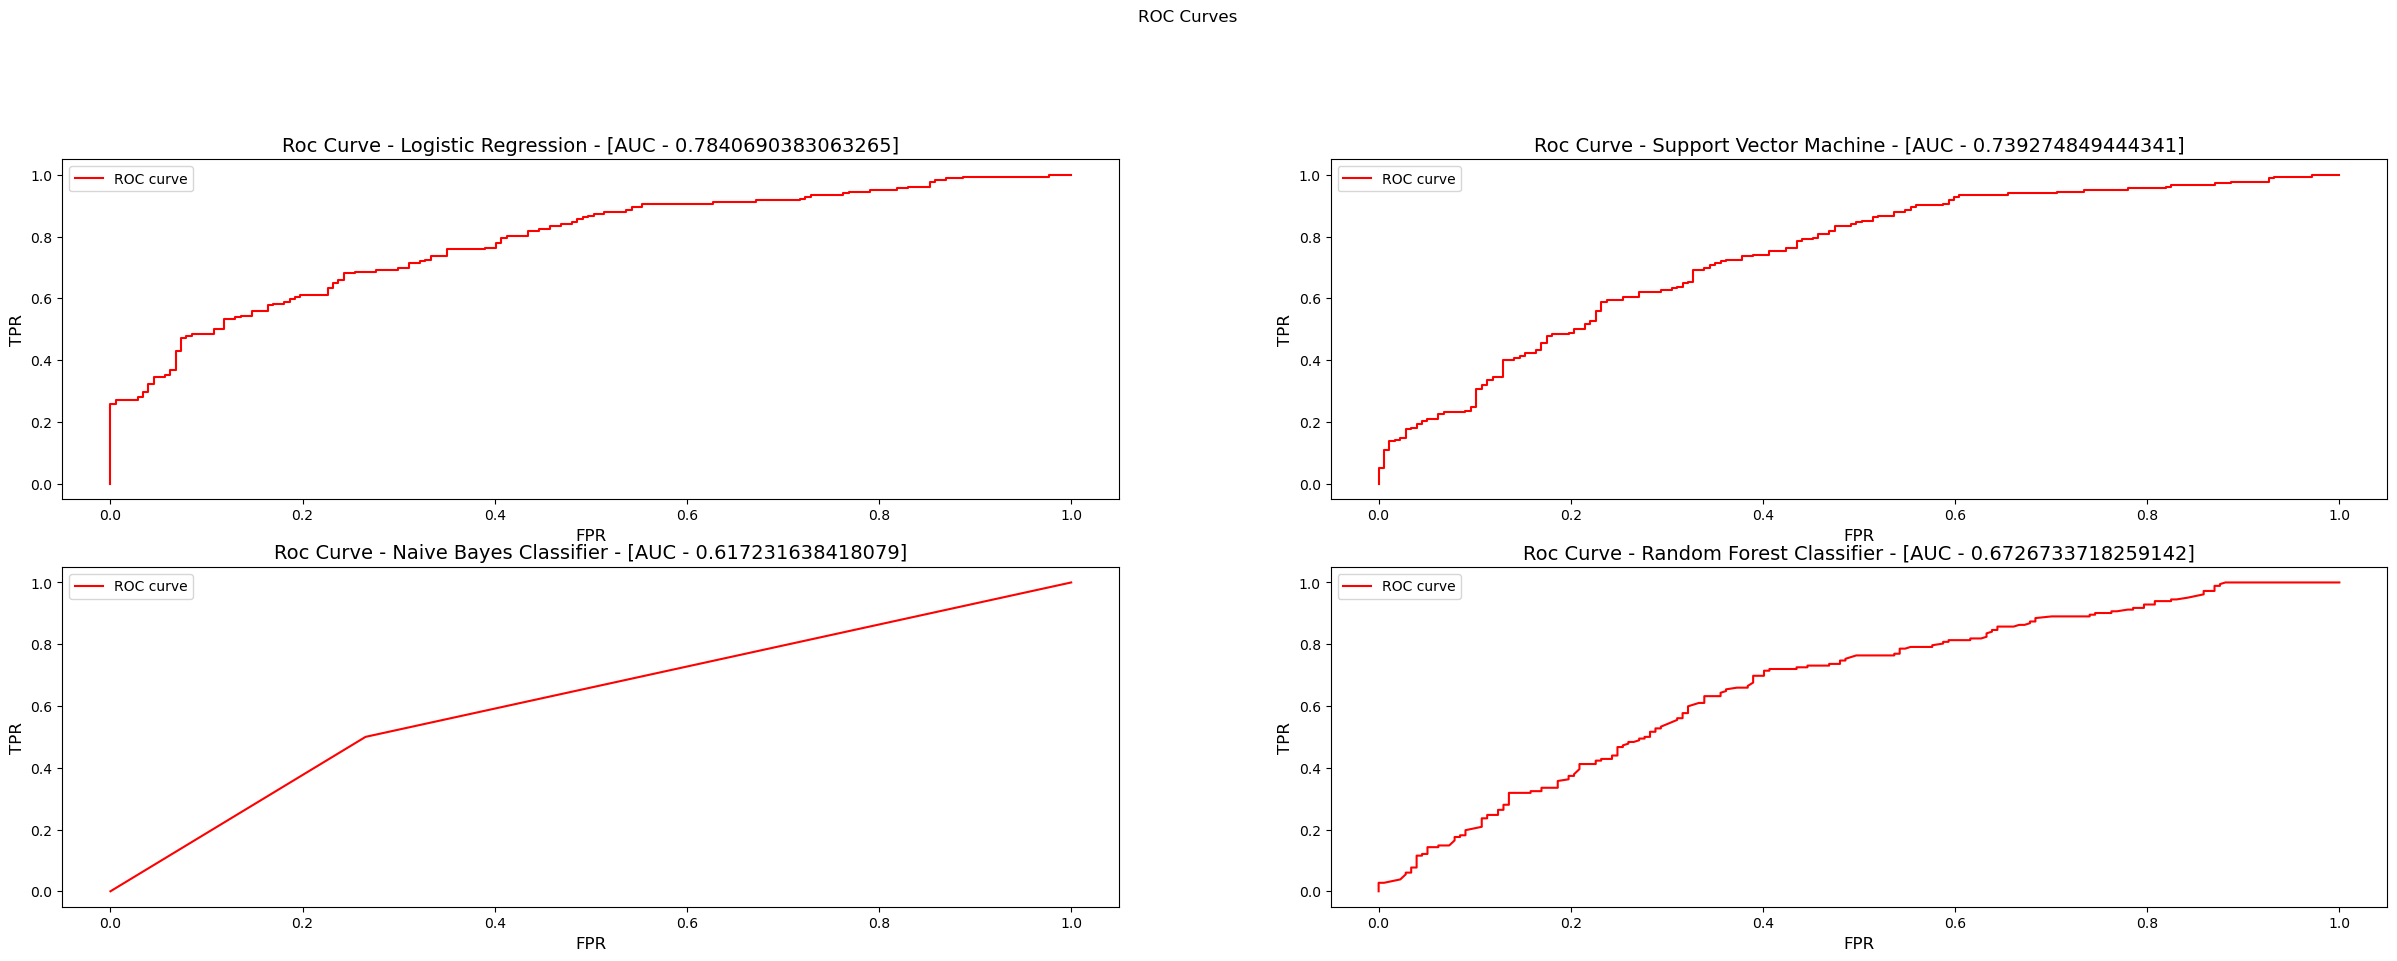

In [38]:
y_lc_predicted_BOW = lc_BOW.predict(x_test)
y_lc_pred_proba_BOW = lc_BOW.predict_proba(x_test)


y_svc_predicted_BOW = svc_BOW.predict(x_test)
y_svc_pred_proba_BOW = svc_BOW.predict_proba(x_test)

# these need to be converted to arrays. They don't handle sparse matrices well
y_nbc_predicted_BOW = nbc_BOW.predict(x_test.toarray())
y_nbc_pred_proba_BOW = nbc_BOW.predict_proba(x_test.toarray())

y_rfc_predicted_BOW = rfc_BOW.predict(x_test)
y_rfc_pred_proba_BOW = rfc_BOW.predict_proba(x_test)


# print classification reports for all models, ensure that zero division does not occur
print('Linear Regression: \n', classification_report(y_test, y_lc_predicted_BOW, zero_division=1)) 
print('SVM: \n', classification_report(y_test, y_svc_predicted_BOW, zero_division=1))
print('Naive Bayes: \n', classification_report(y_test, y_nbc_predicted_BOW, zero_division=1))
print('Random Forest: \n', classification_report(y_test, y_rfc_predicted_BOW, zero_division=1))


# plot models using confusion matrices
models_BOW = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions_BOW = [y_lc_predicted_BOW, y_svc_predicted_BOW, y_nbc_predicted_BOW, y_rfc_predicted_BOW]
pred_probabilities_BOW = [y_lc_pred_proba_BOW, y_svc_pred_proba_BOW, y_nbc_pred_proba_BOW, y_rfc_pred_proba_BOW]

plot = 1

for model_BOW, prediction_BOW, pred_proba_BOW in zip(models_BOW, predictions_BOW, pred_probabilities_BOW):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction_BOW))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model_BOW} Confusion Matrix")

    
# plot ROC curves for all models
plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model_BOW, prediction_BOW, pred_proba_BOW in zip(models_BOW, predictions_BOW, pred_probabilities_BOW):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_BOW[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model_BOW} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

## TF*IDF

### Build Classification Models for TF*IDF

In [40]:
tf_idf = TfidfVectorizer()

# chose to use lemmatized text as I found it had better results
x_train = tf_idf.fit_transform(training['Text_Lemma'])
y_train = training['Sentiment']

x_test = tf_idf.transform(testing['Text_Lemma'])
y_test = testing['Sentiment']

x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

# Use SMOTE to address class imbalance
oversample = SMOTE(random_state = 420)
x_train_balanced, y_train_balanced = oversample.fit_resample(x_train_scaled, y_train)


# Created in attempt to find best model but takes too much time. Not sure if it works?
"""
# For Logistic Regression
param_grid_lc = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_lc = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lc, scoring='f1_macro')
grid_search_lc.fit(x_train_balanced, y_train_balanced)
lc_IDF = grid_search_lc.best_estimator_

# For SVM
param_grid_svc = {'C': [0.1, 1, 10, 100, 1000],
                  'kernel': ['linear', 'rbf']}
grid_search_svc = GridSearchCV(SVC(probability=True), param_grid_svc, scoring='f1_macro')
grid_search_svc.fit(x_train_balanced, y_train_balanced)
svc_IDF = grid_search_svc.best_estimator_

"""

# create models to be trained
lc_IDF = LogisticRegression(max_iter = 1000) # increase number of iterations in hopes of better results
svc_IDF = SVC(probability=True)
nbc_IDF = GaussianNB()
rfc_IDF = RandomForestClassifier()

# TRAIN data
lc_IDF.fit(x_train_balanced, y_train_balanced)
svc_IDF.fit(x_train_balanced, y_train_balanced)
nbc_IDF.fit(x_train_balanced.toarray(), y_train_balanced)
rfc_IDF.fit(x_train_balanced, y_train_balanced)

RandomForestClassifier()

Linear Regression: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       177
           1       0.51      1.00      0.67       182

    accuracy                           0.51       359
   macro avg       0.75      0.50      0.34       359
weighted avg       0.75      0.51      0.34       359

SVM: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       177
           1       0.51      1.00      0.67       182

    accuracy                           0.51       359
   macro avg       0.75      0.50      0.34       359
weighted avg       0.75      0.51      0.34       359

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.59      0.73      0.65       177
           1       0.66      0.50      0.57       182

    accuracy                           0.62       359
   macro avg       0.62      0.62      0.61       359
weighted avg       0.62      0.

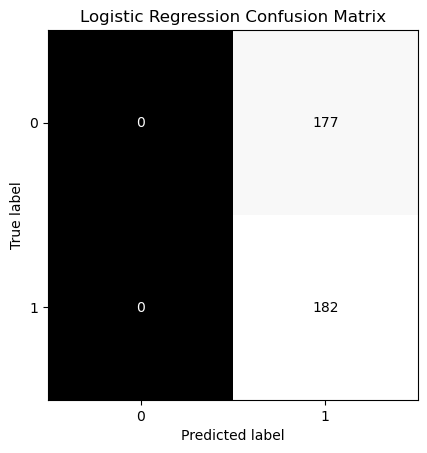

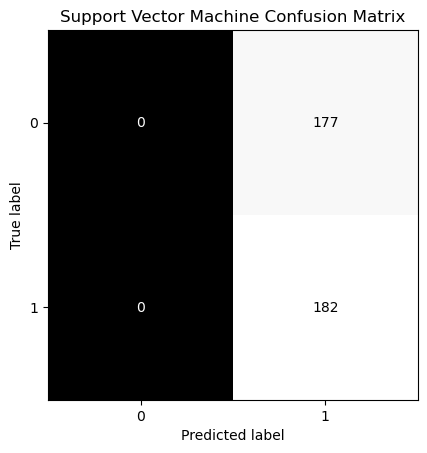

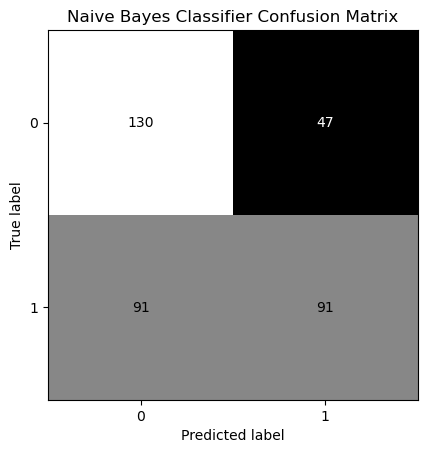

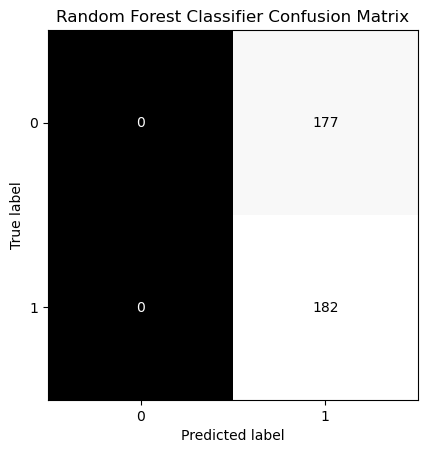

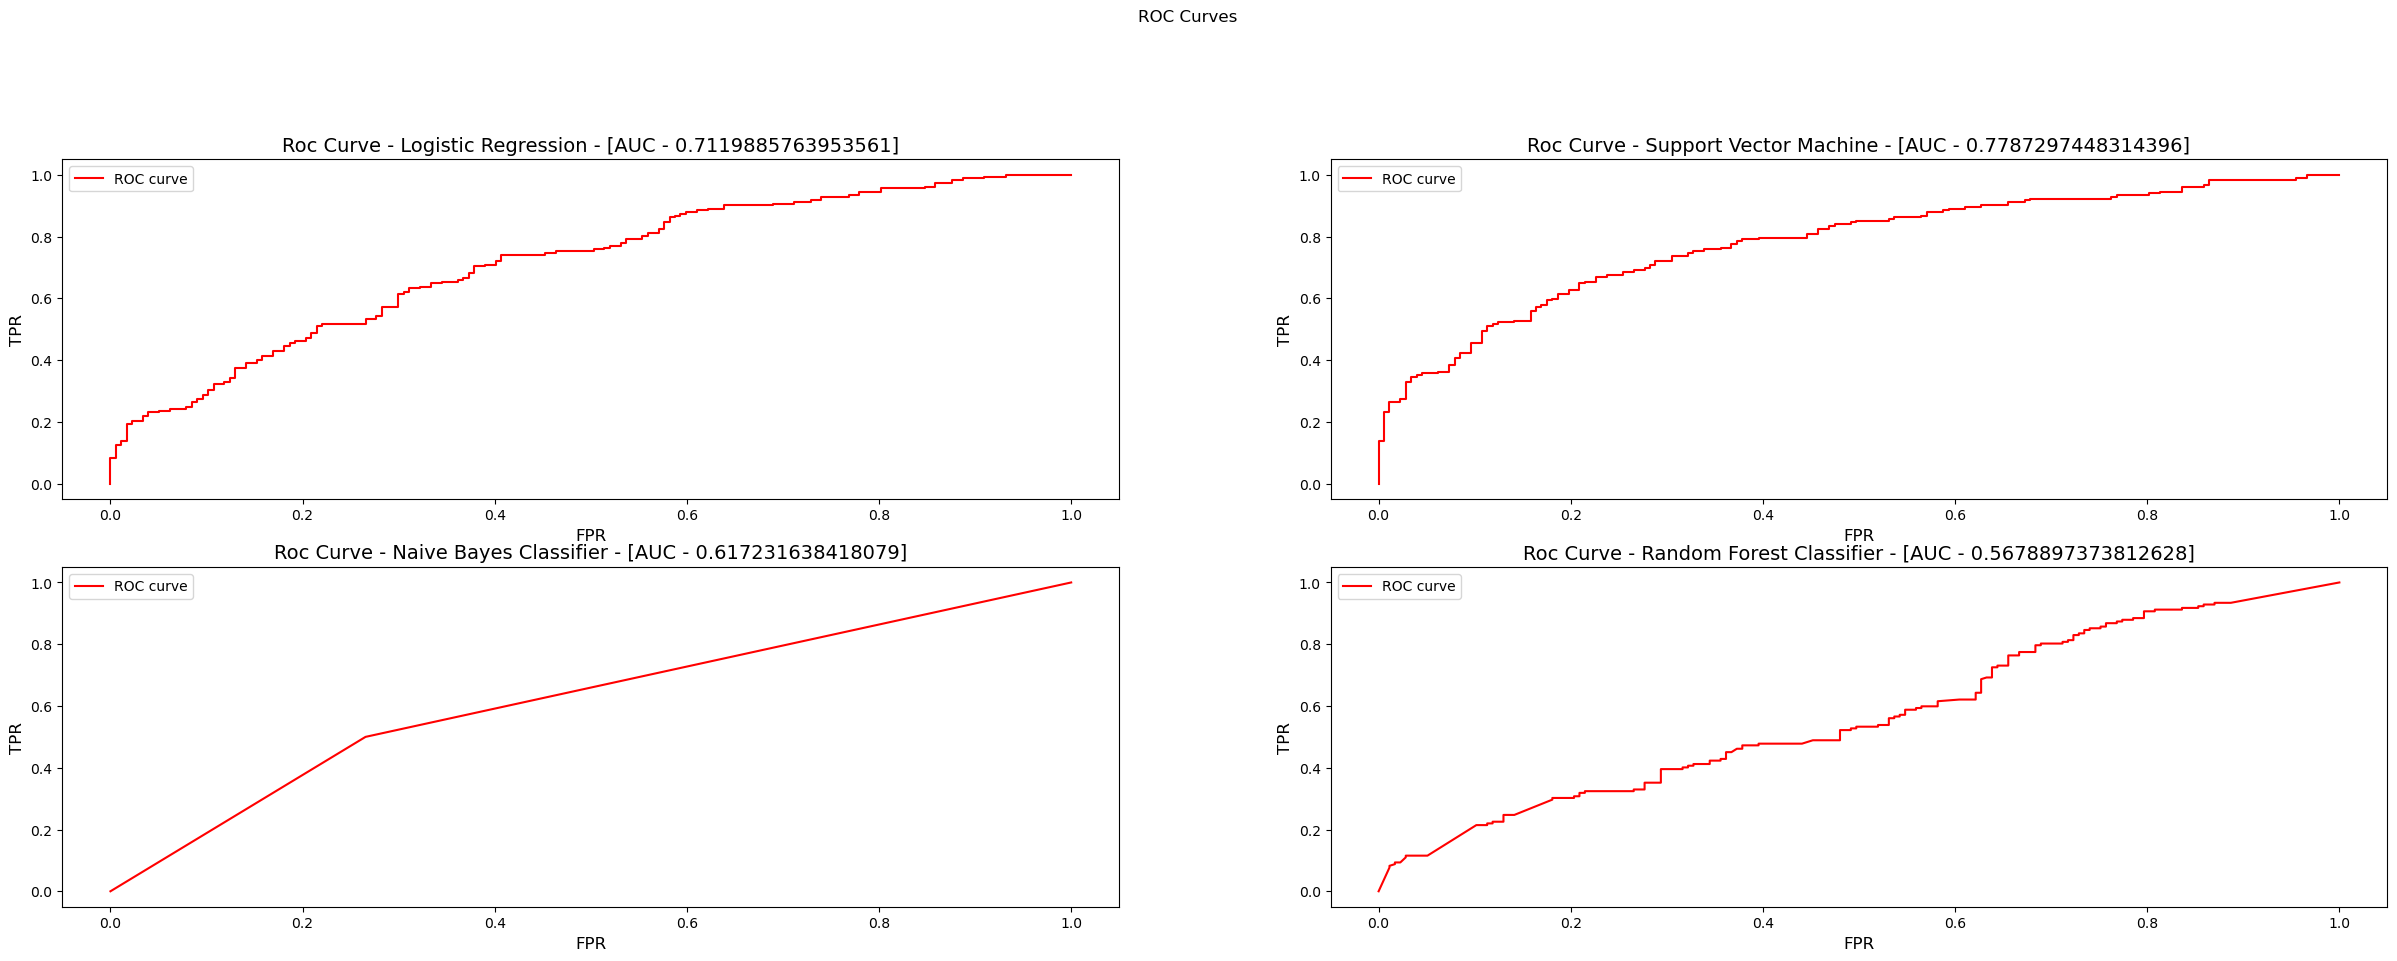

In [41]:
# See how the models perform with our test data
y_lc_predicted_IDF = lc_IDF.predict(x_test)
y_lc_pred_proba_IDF = lc_IDF.predict_proba(x_test)

y_svc_predicted_IDF = svc_IDF.predict(x_test)
y_svc_pred_proba_IDF = svc_IDF.predict_proba(x_test)

y_nbc_predicted_IDF = nbc_IDF.predict(x_test.toarray())
y_nbc_pred_proba_IDF = nbc_IDF.predict_proba(x_test.toarray())

y_rfc_predicted_IDF = rfc_IDF.predict(x_test)
y_rfc_pred_proba_IDF = rfc_IDF.predict_proba(x_test)


# print classification reports for all models
print('Linear Regression: \n', classification_report(y_test, y_lc_predicted_IDF, zero_division=1)) # ensure no division by 0
print('SVM: \n', classification_report(y_test, y_svc_predicted_IDF, zero_division=1)) # ensure no division by 0
print('Naive Bayes: \n', classification_report(y_test, y_nbc_predicted_IDF, zero_division=1)) # ensure no division by 0
print('Random Forest: \n', classification_report(y_test, y_rfc_predicted_IDF, zero_division=1)) # ensure no division by 0


# plot models using confusion matrices
models_IDF = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions_IDF = [y_lc_predicted_IDF, y_svc_predicted_IDF, y_nbc_predicted_IDF, y_rfc_predicted_IDF]
pred_probabilities_IDF = [y_lc_pred_proba_IDF, y_svc_pred_proba_IDF, y_nbc_pred_proba_IDF, y_rfc_pred_proba_IDF]

plot = 1

# display confusion matrices for each of models
for model_IDF, prediction_IDF, pred_proba_IDF in zip(models_IDF, predictions_IDF, pred_probabilities_IDF):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction_IDF)) 
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model_IDF} Confusion Matrix")

    
# plot ROC curves for all models
plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model_IDF, prediction_IDF, pred_proba_IDF in zip(models_IDF, predictions_IDF, pred_probabilities_IDF):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_IDF[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model_IDF} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

## Word2Vec

### Create Word2Vec and Train Classification Models

In [6]:
from keras.callbacks import EarlyStopping

# Tokenize the lemmatized sentences
train_corpus = [nltk.word_tokenize(sentence) for sentence in training['Text_Lemma']]
test_corpus = [nltk.word_tokenize(sentence) for sentence in testing['Text_Lemma']]



# Initialize the Word2Vec model
w2v_model = gensim.models.Word2Vec(vector_size=100,
                                   window=5,
                                   min_count=1,
                                   workers=2)

# Build the vocabulary
w2v_model.build_vocab(train_corpus)



# Function to average word vectors in a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = numpy.zeros((num_features,), dtype="float64") # Initialize the feature vector with zeros
    nwords = 0. # Initialize the word counter as a float
    for word in words:
        if word in vocabulary: # Check if the word is in the vocabulary and not a stop word
            nwords = nwords + 1.
            feature_vector = numpy.add(feature_vector, model.wv[word]) # Add the vector for the word to the feature vector
    if nwords:
        feature_vector = numpy.divide(feature_vector, nwords) # Compute the average vector for the sentence
    return feature_vector

# Function to apply the average_word_vectors function on the tokenized corpus
def averaged_word_vectorizer(corpus, model, num_features):
    '''
    This function takes a tokenized corpus, a trained Word2Vec model, and the number of features as input,
    and returns an array of averaged word vectors for the entire corpus.
    '''
    vocabulary = set(model.wv.index_to_key) # Get the vocabulary of the Word2Vec model
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus] # Apply the average_word_vectors function to each sentence in the corpus
    return numpy.array(features)

# Get the sentence vectors for training and testing data
x_train = averaged_word_vectorizer(train_corpus, w2v_model, 100) # compute averaged word vectors with size 100 for the training corpus
x_test = averaged_word_vectorizer(test_corpus, w2v_model, 100) # compute averaged word vectors with size 100 for the test corpus

y_train = training['Sentiment']
y_test = testing['Sentiment']

# Use SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
oversample = SMOTE(random_state = 420)
x_train_balanced, y_train_balanced = oversample.fit_resample(x_train, y_train)

# Create models to be trained
lc_W2V = LogisticRegression()
svc_W2V = SVC(probability=True)
nbc_W2V = GaussianNB()
rfc_W2V = RandomForestClassifier()

# Train the models using the balanced data
lc_W2V.fit(x_train_balanced, y_train_balanced)
svc_W2V.fit(x_train_balanced, y_train_balanced)
nbc_W2V.fit(x_train_balanced, y_train_balanced)
rfc_W2V.fit(x_train_balanced, y_train_balanced)

2023-03-21 23:41:35.659376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1, Loss: 0.0, Improvement: inf
Epoch 2, Loss: 0.0, Improvement: 0.0
Epoch 3, Loss: 0.0, Improvement: 0.0
Epoch 4, Loss: 0.0, Improvement: 0.0
Epoch 5, Loss: 0.0, Improvement: 0.0
Epoch 6, Loss: 0.0, Improvement: 0.0
Early stopping at epoch 6


Linear Regression: 
               precision    recall  f1-score   support

           0       0.67      0.41      0.51       177
           1       0.58      0.80      0.68       182

    accuracy                           0.61       359
   macro avg       0.63      0.61      0.59       359
weighted avg       0.63      0.61      0.59       359

SVM: 
               precision    recall  f1-score   support

           0       0.48      0.42      0.45       177
           1       0.50      0.56      0.53       182

    accuracy                           0.49       359
   macro avg       0.49      0.49      0.49       359
weighted avg       0.49      0.49      0.49       359

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.45      0.50      0.47       177
           1       0.45      0.41      0.43       182

    accuracy                           0.45       359
   macro avg       0.45      0.45      0.45       359
weighted avg       0.45      0.

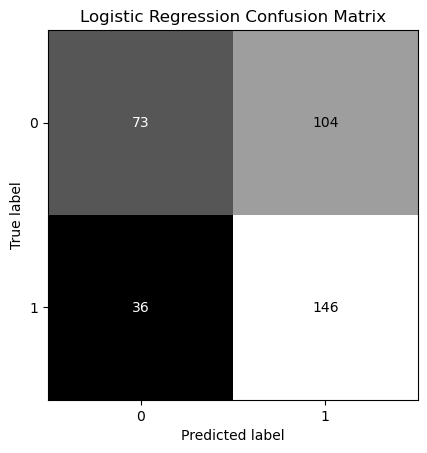

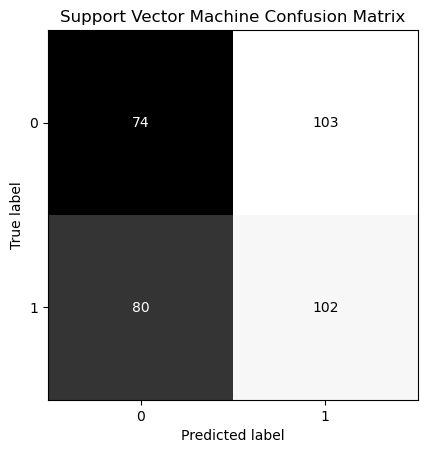

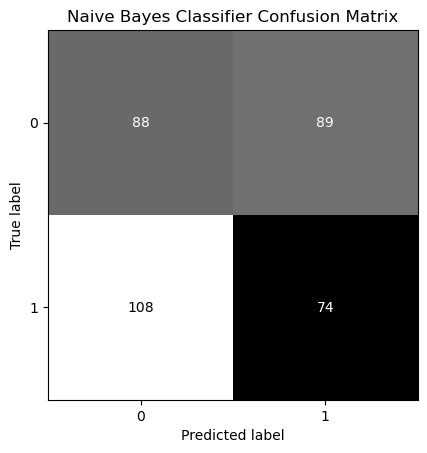

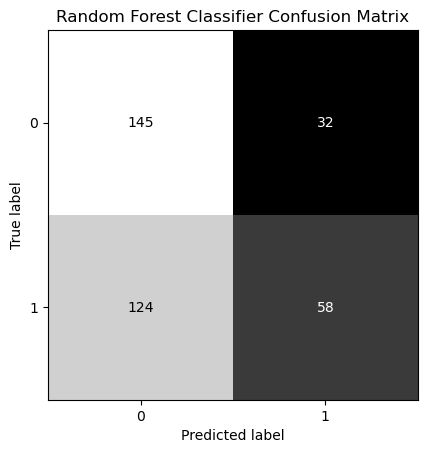

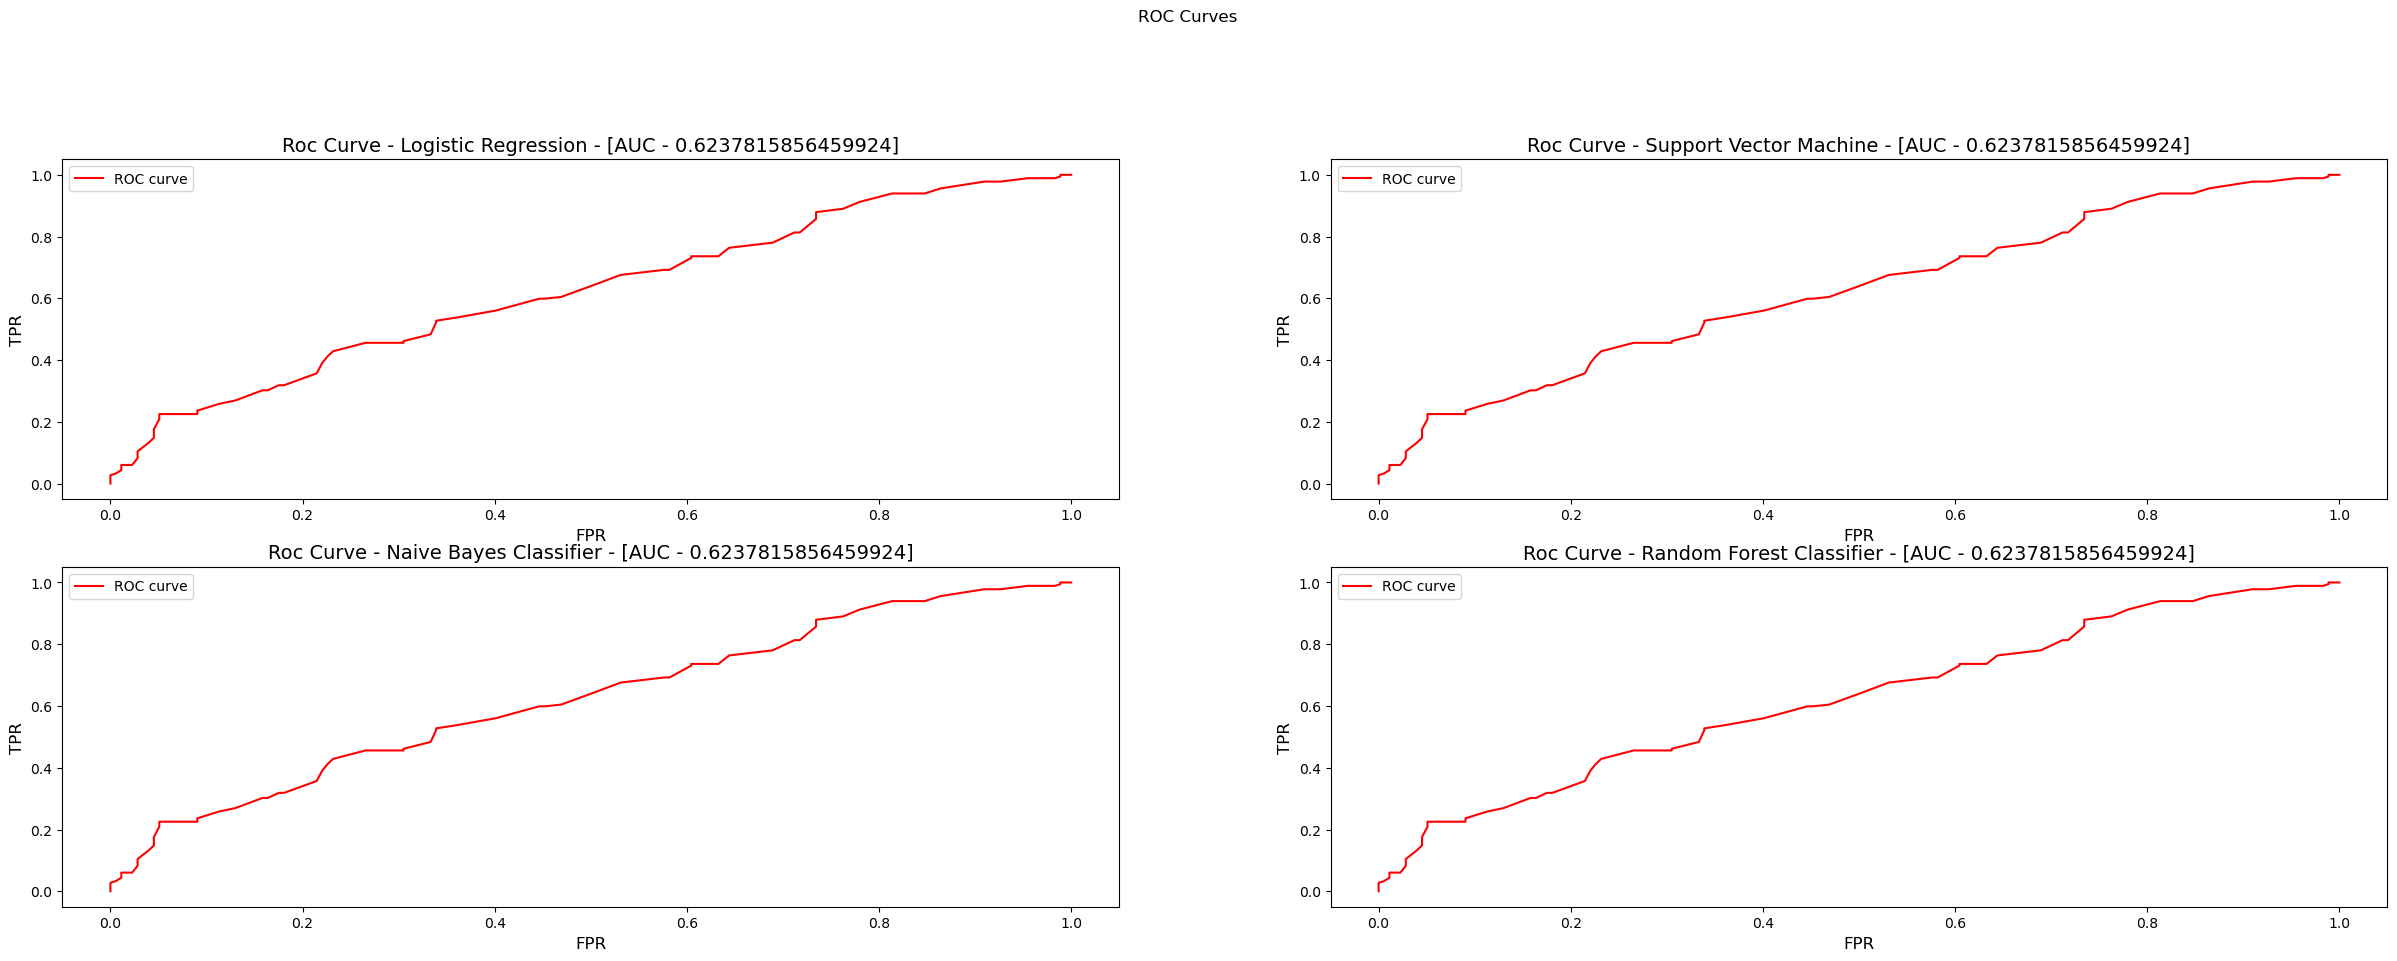

In [45]:
y_lc_predicted_W2V = lc_W2V.predict(x_test)
y_lc_pred_proba_W2V = lc_W2V.predict_proba(x_test)


y_svc_predicted_W2V = svc_W2V.predict(x_test)
y_svc_pred_proba_W2V = svc_W2V.predict_proba(x_test)

y_nbc_predicted_W2V = nbc_W2V.predict(x_test)
y_nbc_pred_proba_W2V = nbc_W2V.predict_proba(x_test)

y_rfc_predicted_W2V = rfc_W2V.predict(x_test)
y_rfc_pred_proba_W2V = rfc_W2V.predict_proba(x_test)


# print classification reports for all models
print('Linear Regression: \n', classification_report(y_test, y_lc_predicted_W2V, zero_division=1))
print('SVM: \n', classification_report(y_test, y_svc_predicted_W2V, zero_division=1))
print('Naive Bayes: \n', classification_report(y_test, y_nbc_predicted_W2V, zero_division=1))
print('Random Forest: \n', classification_report(y_test, y_rfc_predicted_W2V, zero_division=1))


# plot models using confusion matrices
models_W2V = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions_W2V = [y_lc_predicted_W2V, y_svc_predicted_W2V, y_nbc_predicted_W2V, y_rfc_predicted_W2V]
pred_probabilities_W2V = [y_lc_pred_proba_W2V, y_svc_pred_proba_W2V, y_nbc_pred_proba_W2V, y_rfc_pred_proba_W2V]

plot = 1

for model_W2V, prediction_W2V, pred_proba_W2V in zip(models_W2V, predictions_W2V, pred_probabilities_W2V):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction_W2V))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model_W2V} Confusion Matrix")

    
# plot ROC curves for all models
plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model_W2V, prediction_W2V, pred_proba_IDF in zip(models_W2V, predictions_W2V, pred_probabilities_W2V):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_W2V[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model_W2V} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()